In [34]:
# data preprossessing
import os
import re
import random
import numpy as np
import unicodedata
from io import open
from sklearn.model_selection import train_test_split
# helper
import time
import math
# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('ggplot') # plot style
mpl.rcParams["font.size"] = 18 # font size
plt.switch_backend('agg') # remove it if using terminal
# pytorch packages
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from src.attention.masked_cross_entropy import *
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

USE_CUDA = False

## * Helper function

In [2]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm:%ds' % (m, s)

def timer(since, percent):
    now = time.time()
    s = now - since # time elapsed
    es = s / (percent) # total time estimated
    rs = es - s # time left
    return "time used %s left %s" % (as_minutes(s), as_minutes(rs))

def del_save(file_path):
	try:
	    os.remove(file_path)
	except OSError:
	    pass

# Data preparation

## 1. Token class

In [3]:
class vocab:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'PAD', 1: 'SOS', 2: 'EOS'}
        self.n_words = 3  # Count PAD, SOS and EOS
        self.max_length = 1

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
    def addSentence(self, sentence):
        i = 0
        for word in sentence.split():
            self.addWord(word)
            i+=1
        if i > self.max_length:
            self.max_length = i    

## 2. Clean text: remove punctuations, truncate the length and group into pairs

In [10]:
# remove punctuations
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z]+", r" ", s)
    return s

In [11]:
def read_data(data_path):        
    '''
    Return cleaned a list of pairs, e.g. [[pair1, pair2], [pair3, pair4], ...]
    '''
    # Read the file and split into lines
    lines = open(data_path, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = []
    for i in range(0,len(lines)-1): # be careful of step=2
        pairs.append([normalizeString(lines[i]), normalizeString(lines[i+1])])
    return pairs

In [12]:
# trim the pairs by max_length
def filterPair(p, MAX_LENGTH):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs, MAX_LENGTH):
    return [pair for pair in pairs if filterPair(pair, MAX_LENGTH)]

In [13]:
# data cleaning in one function

def prep_data(data_dir, MAX_LENGTH):
    '''
    Return vocab instance, and trimed and cleaned pairs
    '''
    # obtain all data_paths from data_dir    
    data_list = []
    for subdir, dirs, files in os.walk(data_dir):
        for file in files:
            data_list.append(os.path.join(subdir, file))
    pairs_total = []
    # instantial vocab class
    lang = vocab()
    print('<====================| Data Cleaning |====================>')
    # iterate through all files
    for itr, data_path in enumerate(data_list):
        # get pairs
        pairs_raw = read_data(data_path)
        # filter by max_length
        pairs_trimed = filterPairs(pairs_raw, MAX_LENGTH)     
        # concatenate pairs
        pairs_total += pairs_trimed
        # initialize vocab instance
        for pair in pairs_trimed:
            lang.addSentence(pair[0])
            lang.addSentence(pair[1])
        print("<===| Read {:d} sentence pairs from Doc {:d} | Trimmed to {:d} sentence pairs | Counted {:d} unique words in total|===>\n"
            .format(len(pairs_raw), itr+1, len(pairs_trimed),lang.n_words))

    return lang, pairs_total

In [14]:
# test things out
data_path = 'data/pop'
lang, pairs = prep_data(data_path, MAX_LENGTH = 20)
print(random.choice(pairs))

<====================| Data Cleaning |====================>
<===| Read 11173 sentence pairs from Doc 1 | Trimmed to 11161 sentence pairs | Counted 3083 unique words in total|===>

['but we still can change some things today ', 'in our small way']


## 3. Tensorization (pair -> split -> add EOS token -> tensor -> integer encoding)

In [15]:
# string to index, datatype -> tensor
# Return a list of indexes, one for each word in the sentence, plus EOS
def indexes_from_sentence(lang, sentence, EOS_token):
    return [lang.word2index[word] for word in sentence.split()] + [EOS_token]

# Pad a with the PAD symbol
def pad_seq(seq, max_length, PAD_token):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq

## 4. Batch data

In [16]:
def random_batch(batch_size, lang, pairs, USE_CUDA=True):
	'''
	input -> batch_size
	return -> input/output of a batch, array of lengths of input/output
	batched data -> max_len x batch_size (note that this is required size feeding to gru layer)
	'''
	PAD_token = 0
	EOS_token = 2

	input_seqs = []
	target_seqs = []

	# integer encoding randomly picked samples of a batch
	for i in range(batch_size):
	    pair = random.choice(pairs)
	    input_seqs.append(indexes_from_sentence(lang, pair[0], EOS_token))
	    target_seqs.append(indexes_from_sentence(lang, pair[1], EOS_token))

	# rearrange seqs in a descending order
	seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
	input_seqs, target_seqs = zip(*seq_pairs)

	# For input and target sequences, get array of lengths and pad with 0s to max length
	input_lengths = [len(s) for s in input_seqs] # lengths of each seq in a batch
	input_padded = [pad_seq(s, max(input_lengths), PAD_token) for s in input_seqs]
	target_lengths = [len(s) for s in target_seqs]
	target_padded = [pad_seq(s, max(target_lengths), PAD_token) for s in target_seqs]

	# Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
	input_batch = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
	target_batch = Variable(torch.LongTensor(target_padded)).transpose(0, 1)

	if USE_CUDA:
	    input_batch = input_batch.cuda()
	    target_batch = target_batch.cuda()
	    
	return input_batch, input_lengths, target_batch, target_lengths

In [19]:
# try it out
batch_size = 3
print(random_batch(batch_size, lang, pairs))

(tensor([[  35,   34,    2],
        [  78,    2,    0],
        [  68,    0,    0],
        [ 154,    0,    0],
        [  14,    0,    0],
        [ 400,    0,    0],
        [  31,    0,    0],
        [  35,    0,    0],
        [1166,    0,    0],
        [ 932,    0,    0],
        [   2,    0,    0]], device='cuda:0'), [11, 2, 1], tensor([[2751,    2,   32],
        [2752,    0, 1615],
        [   2,    0,   41],
        [   0,    0, 1483],
        [   0,    0,   41],
        [   0,    0, 1707],
        [   0,    0,    2]], device='cuda:0'), [3, 1, 7])


## 5. Pretrained embeddings

In [31]:
# pretrained word embedding
def pretrained(glove_path):
    '''
    load pretrained glove and return it as a dictionary
    '''
    # dimension of import word2vec file
    glove = {}
    with open(glove_path,'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            glove[word] = coefs
    return glove

def embeds(lang, EMBEDDING_DIM, non_trainable=True):
    '''
    match pretrained embedding and dataset
    embedding -> unique_words x emb_size
    '''
    # load glove
    glove_path = 'data/glove.6B.50d.txt'
    glove = pretrained(glove_path)
    # initialize embedding matrix for our dataset
    embedding_matrix = np.zeros((lang.n_words, EMBEDDING_DIM))
    # count words that appear only in the dataset. word_index.items() yields dict of word:index pair
    for word, ix in lang.word2index.items():
        embedding_vector = glove.get(word)
        if embedding_vector is not None:
            # words not found in glove matrix will be all-zeros.
            embedding_matrix[ix] = embedding_vector
    # change the datatype from numpy_array to torch_tensor
    weight = torch.FloatTensor(embedding_matrix)
    # convert to the embedding of pytorch
    embedding_matrix = nn.Embedding.from_pretrained(weight)
    # make it non-trainable
    if non_trainable:
        embedding_matrix.weight.requires_grad = False
    
    return embedding_matrix, glove

# Model structure

In [20]:
class EncoderRNN(nn.Module):
    def __init__(self, lang, hidden_size, n_layers=1, dropout=0.1, pretrained=True):
        super(EncoderRNN, self).__init__()
        
        self.lang = lang
        self.input_size = lang.n_words
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout

        if not pretrained:
            self.embedding = nn.Embedding(self.input_size, hidden_size)
        else:    
            self.embedding, _ = embeds(lang, hidden_size)

        # GRU layer 
        # first two parameters are emb_dim and hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        '''
        hidden=None initializes hidden unit with satisfying dimension
        input -> S x B, embedded -> S x B x N, hidden -> 2*2 x B x N
        output_raw -> S x B x 2N, hidden -> 4 x B x N (2layers x bidirection = 4)
        output -> S x B x N, which is the sum of bidirectional outputs
        output_raw concats two results
        '''
        embedded = self.embedding(input_seqs)
        packed = pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = pad_packed_sequence(outputs) # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        
        return outputs, hidden

In [21]:
# This is just the class calcuating the attention weights. NOT a decoder unit.
class Attn(nn.Module):
    def __init__(self, method, hidden_size, USE_CUDA):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        self.USE_CUDA = USE_CUDA
        
        if self.method == 'general':
            self.attn = nn.Linear(hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        # hidden is the output from decoder -> 1 x B x N
        # encoder_outputs -> S x B x N
        max_len = encoder_outputs.size(0)
        batch_size = encoder_outputs.size(1)
        # attention weights -> B x S
        attn_energies = Variable(torch.zeros(batch_size, max_len))

        if self.USE_CUDA:
            attn_energies = attn_energies.cuda()

        # For each batch of encoder outputs
        for b in range(batch_size):
            # Calculate energy for each encoder output
            for i in range(max_len):
                # hidden -> 1 x B x N, encoder_outputs -> S x B x N
                # hidden[:, b].squeeze() -> N, encoder_outputs[i, b] -> N
                attn_energies[b, i] = self.score(hidden[:, b].squeeze(), encoder_outputs[i, b])

        # Normalize energies to weights in range 0 to 1
        # dim =0 along column, dim=1 along row. here it renormalizes all words within each batch
        return F.softmax(attn_energies, dim=1).unsqueeze(1) # B x S -> B x 1 x S
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.view(-1).dot(encoder_output.view(-1))
            return energy
        
        # dot product of two vectors with length N
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.v.dot(energy)
            return energy

In [22]:
# Luong attention
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, lang, hidden_size, n_layers=1, dropout=0.1, pretrained=True, USE_CUDA=True):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        # parameters for embedding layer
        self.lang = lang
        self.output_size = lang.n_words
        self.hidden_size = hidden_size
        # parameters for GRU layer
        self.n_layers = n_layers
        self.dropout = dropout
        self.USE_CUDA = USE_CUDA

        # Define layers
        if not pretrained:
            self.embedding = nn.Embedding(self.output_size, hidden_size)
        else:    
            self.embedding, _ = embeds(lang, hidden_size)
        # dropout layer
        self.embedding_dropout = nn.Dropout(dropout)
        # unidirectionoal GRU
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        # concat layer reduces length from 2N to N
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, self.output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size, USE_CUDA)
            
    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time

        # input_seq starts with a vector of size batch_size x 1 (SOS_tokens)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq) # batch_size x 1 x N
        embedded = self.embedding_dropout(embedded)
        # as input_seq -> batch_size x 1, we need to reshape it
        embedded = embedded.view(1, batch_size, self.hidden_size) # 1 x B x N
        ########################################################################################    
        # Get current hidden state from input word and last hidden state
        # embedded -> 1 x B x N, last_hidden -> 2 x B x N
        # rnn_output -> 1 x B x N, hidden -> 2 x B x N (2layers x unidirection = 2)
        rnn_output, hidden = self.gru(embedded, last_hidden)
        ########################################################################################
        # attention weights is the dot product between rnn_outputs and encoder_outputs
        # rnn_output -> 1 x B x N, encoder_outputs -> S x B x N
        # attn_weights -> B x 1 x S
        attn_weights = self.attn(rnn_output, encoder_outputs) # self.attn calls Attn
        # attn_weights -> B x 1 x S
        # encoder_outputs.transpose(0, 1) -> B x S x N
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x (S=1) x N
        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0) # rnn_output -> B x N
        context = context.squeeze(1)       # context -> B x N
        # concat rnn_output and context(weighted output from encoder)
        concat_input = torch.cat((rnn_output, context), 1) # 0:row, 1:col | concat_input -> B x 2N
        concat_output = torch.tanh(self.concat(concat_input)) # go through tanh
        ########################################################################################
        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output) # just a linear layer

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

In [23]:
# Bahdanau attention
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(BahdanauAttnDecoderRNN, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = Attn('concat', hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        # TODO: FIX BATCHING
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        word_embedded = self.dropout(word_embedded)
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        context = context.transpose(0, 1) # 1 x B x N
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        output = F.log_softmax(self.out(torch.cat((output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

# Training Iteration

In [24]:
def train(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, clip, USE_CUDA=True):
    '''
    This is the train funtion for batch data
    '''

    # Enable train mode
    encoder.train()
    decoder.train()

    SOS_token = 1
    EOS_token = 2
    # note that data has size max_len x batch_size
    batch_size = input_batches.size(1) # input and target have the same batch_size
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    # outputs -> S x B x N, hidden -> 4 x B x N
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    # decoder_input -> batch_size x 1
    decoder_input = Variable(torch.LongTensor([[SOS_token] * batch_size])).transpose(0, 1)
    # decoder_hidden -> 2 x B x N
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder   
    # max_length of target data
    max_target_length = max(target_lengths)
    # all_decoder_outputs -> S x B x N
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))

    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # Teacher Forcing vs. Scheduled Sampling
    teacher_forcing_ratio = 0.5 # threshold value
    # use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    use_teacher_forcing = True

    # Exploitation
    if use_teacher_forcing:    
        # Run through decoder one time step at a time
        for t in range(max_target_length):
            decoder_output, decoder_hidden, decoder_attn = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # decoder_output -> 1 x batch_size x n_words
            all_decoder_outputs[t] = decoder_output # save it to all_decoder_outputs
            decoder_input = target_batches[t] # teacher forcing

    # Exploration
    # else:
    #     for t in range(max_target_length):
    #         decoder_output, decoder_hidden, decoder_attn = decoder(
    #             decoder_input, decoder_hidden, encoder_outputs)
    #         # obtain the prediction as new decoder_input
    #         all_decoder_outputs[t] = decoder_output
    #         # topi -> batch_size, cannot use .item() to convert to python scalars
    #         topv, topi = decoder_output.topk(1)            
    #         ixs = topi.squeeze().detach().cpu().numpy() # detach from history as input
    #         # set up next decoder input
    #         decoder_input = Variable(torch.LongTensor([ixs]))
    #         print(decoder_input.size())
    #         if USE_CUDA: decoder_input = decoder_input.cuda()
            # for ix in np.where(ixs == EOS_token):
            #     append EOS token
            #     pad the rest of the sentence with PAD token  
            #     save it somewhere and take it off from input
            #     
            # if ix == EOS_token:
            #     decoded_words.append('<EOS>')
            #     break
            # else:
            #     decoded_words.append(lang.index2word[ix])
           
    # calculate loss
    loss = masked_cross_entropy(
    all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
    target_batches.transpose(0, 1).contiguous(), # -> batch x seq
    target_lengths)

    # accumulate gradients
    loss.backward()
    
    # Clip gradient norms to prevent exploding gradient issue
    # clip_grad_value_ clip grad between (-clip, +clip)
    # clip_grad_norm_ clip grad to a single value clip
    ec = torch.nn.utils.clip_grad_value_(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_value_(decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()

In [62]:
def trainIter(n_epochs, batch_size, lang, pairs, encoder, decoder, learning_rate = 0.0001, decoder_learning_ratio = 5.0):
    
    loss_array = []
    
    start = time.time()

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
    
    # train/test split
    pairs_train, pairs_test = train_test_split(pairs, test_size=0.2, random_state=666)
    
    epoch = 0
    while epoch < n_epochs:
        
        if epoch%10 ==0: print('{} epochs to run'.format(n_epochs-epoch))

        loss_print = 0
        epoch += 1
        
        
        # Get training data for this cycle
        input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size, lang, pairs_train)

        # Run the train function
        loss, ec, dc = train(input_batches, input_lengths, target_batches, target_lengths,
            encoder, decoder, encoder_optimizer, decoder_optimizer)
        
        loss_array.append(loss)
        ec_array.append(ec)
        dc_array.append(dc)
        loss_print = loss
        
        ######################################################################################
        # validation
        # prepare data for validation
        input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size, lang, pairs_test)
        
        loss = validation(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder)
        
        print('testloss', loss)
        
        
        # print out loss for each epoch
        
        print_summary = "<=== %d%% trained ===> %s loss_train: %.3f loss_test: %.3f <=== dope ===>" % (epoch / n_epochs * 100, time_since(start, epoch / n_epochs), loss_print, loss_print)
        print(print_summary)
    
    return loss_array, ec_array, dc_array
    

In [25]:
def validation(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, USE_CUDA=True):
    
    SOS_token = 1
    loss = 0
    # take the whole validation set as a batch, as there is no need to update parameters
    batch_size = input_batches.size(1)

    # diable dropout and batchnorm
    encoder.eval()
    decoder.eval()
    # disable parameter update
    with torch.no_grad():

        # Run words through encoder
        encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

        # Prepare input and output variables
        decoder_input = Variable(torch.LongTensor([[SOS_token] * batch_size])).transpose(0, 1)
        decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

        # max_length of batch data
        max_target_length = max(target_lengths)
        all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))

        # Move new Variables to CUDA
        if USE_CUDA:
            decoder_input = decoder_input.cuda()
            all_decoder_outputs = all_decoder_outputs.cuda()

        # Run through decoder one time step at a time
        for t in range(max_target_length):
            decoder_output, decoder_hidden, decoder_attn = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            all_decoder_outputs[t] = decoder_output
            decoder_input = target_batches[t] # Next input is current target

        # Loss for batch data
        loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(),
        target_batches.transpose(0, 1).contiguous(),
        target_lengths)
    
    return loss.item()

In [33]:
def trainIter(n_epochs, batch_size, lang, pairs, encoder, decoder, clip, 
    encoder_learning_rate, decoder_learning_rate, test_size, random_state=666):
    # batch_size = 1 # stochastic is reproduce
    # setup start time
    start = time.time()
    # train/test split
    pairs_train, pairs_test = train_test_split(pairs, test_size = test_size, random_state = random_state)
    # initialize optimizer
    encoder_optimizer = optim.Adam(encoder.parameters(), lr = encoder_learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr = decoder_learning_rate)
    # create loss_array
    loss_array = np.empty([2,0]) # initialize an empty 2d array
    # train loop starts from here
    for epoch in range(1, n_epochs+1):
        loss_train, loss_test = 0, 0
        # find the number of loops to run in one epoch   
        # n_iters = 1 # this is for fast debugging purpose
        n_iters = len(pairs)//batch_size
        # iteration of batches starts      
        for itr in range(1, n_iters+1):
            print('<===| Training on epoch:{:d}/{:d} batch:{:d}/{:d}... | {:s} |===>'
                .format(epoch, n_epochs, itr, n_iters, timer(start, itr / n_iters)))
            # Get training data for this cycle
            input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size, lang, pairs_train)
            # Run the train function
            loss_train += train(input_batches, input_lengths, target_batches, target_lengths,
                encoder, decoder, encoder_optimizer, decoder_optimizer, clip) 
            # save model every batch
            torch.save(encoder, 'save/encoder.pt')
            torch.save(decoder, 'save/decoder.pt')
        #####################################################################################################
        # validation
        valid_size = len(pairs_test)
        print('<===| Testing on validation set with {} sentence pairs, please be patient! |===>\n'.format(valid_size))
        input_batches, input_lengths, target_batches, target_lengths = random_batch(valid_size, lang, pairs_test)
        # get loss from validation
        loss_test += validation(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder)
        #####################################################################################################
        # print out loss for each epoch
        print("<===| {:.1%} assignment done | loss_train:{:.1f} | loss_test:{:.1f} | {:s} |===>\n"
        .format(epoch / n_epochs, loss_train, loss_test, timer(start, epoch / n_epochs)))
        # one epoch done!
        epoch += 1
        ######################################################################################################
        # write losses into file for every epoch
        loss_new = np.array([[loss_train, loss_test]])
        loss_array = np.concatenate((loss_array, loss_new.T), axis=1)
        np.save('save/loss.npy', loss_array)

# Run the model

In [ ]:
hidden_size = 50 # embedding_dim, modify preprocessing.embeds accordingly if you want to change this
MAX_LENGTH = 15 # max length to trim
data_dir = 'data/pop' # data_dir
# load/instantiate lang and pairs

lang, pairs = prep_data(data_dir, MAX_LENGTH)

print("<====================| Dataset Summary |====================>")
print("<===| Loaded {:d} sentence pairs | {:d} unique words |===>\n".format(len(pairs), lang.n_words))

#######################################################################################################
# Instantiate encoder/decoder, hyperparameter: dropout, n_layers, attention type, optimizers(given in trainIter)

n_layers = 2 # number of gru layers
dropout=0.1 # dropout rate
attention_model = 'general' # attention type
# instantiate
encoder = EncoderRNN(lang, hidden_size, n_layers)
decoder = LuongAttnDecoderRNN(attention_model, lang, hidden_size, n_layers, dropout)
# enable train mode
encoder.train()
decoder.train()
# Use GPU
if USE_CUDA:
	    encoder = encoder.cuda()
	    decoder = decoder.cuda()

######################################################################################################
# Iteration, corresponding hyperparameters are given below

batch_size = 100
n_epochs = 11
clip = 5.0
encoder_learning_rate = 0.001
decoder_learning_rate = 0.003
test_size = 0.3 # train/validation ratio
random_state = 666 # random_state of train/test split
# let the fun begin
print('<====================| Training Summary |====================>')
print('<===| Epochs:{:d} | BatchSize:{:d} | ClipValue:{:.1f} | EncoderLR:{:.1e} | DecoderLR:{:.1e} | ValidationSize:{:.2f} |===>\n'
	.format(n_epochs, batch_size, clip, encoder_learning_rate, decoder_learning_rate, test_size))
# train model
trainIter(n_epochs, batch_size, lang, pairs, encoder, decoder,
	clip, encoder_learning_rate, decoder_learning_rate, test_size, random_state)


# Evaluation

In [145]:
def evaluate(input_sentence, lang, encoder, decoder, max_length, USE_CUDA=True):
    '''
    this function does greedy search
    '''
    SOS_token = 1
    EOS_token = 2
    
    # diable dropout and batchnorm
    encoder.eval()
    decoder.eval()
    # disable parameter update
    with torch.no_grad():
        # format input_sentence before feeding to the model
        input_sentence = [indexes_from_sentence(lang, input_sentence, EOS_token)]
        input_batches = Variable(torch.LongTensor(input_sentence)).transpose(0, 1)
        input_lengths = [len(input_batches)]
        
        if USE_CUDA:
            input_batches = input_batches.cuda()
        
        # Run through encoder
        encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

        # Create starting vectors for decoder
        decoder_input = Variable(torch.LongTensor([SOS_token])) # SOS
        decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder
        
        if USE_CUDA:
            decoder_input = decoder_input.cuda()

        # Store output words and attention states
        decoded_words = []
        # row
        decoder_attentions = torch.zeros(max_length+1, max_length+1)
        
        # Run through decoder
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze().cpu()
            # Choose top word from output
            topv, topi = decoder_output.topk(1)
            ix = topi.item()
            if ix == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(lang.index2word[ix])
                
            # Next input is chosen word
            decoder_input = Variable(torch.LongTensor([ix]))
            if USE_CUDA: decoder_input = decoder_input.cuda()

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

In [155]:
def plot_attention(input_sentence, output_words, attentions, save_path, color):
    plt.rcParams["axes.grid"] = False # disable grid of plots
    # Set up figure with colorbar
    fig, ax = plt.subplots(figsize=(10,8))
    att = ax.imshow(attentions.numpy(), cmap=color, aspect='auto')
    cbar = fig.colorbar(att)

    # add title
    ax.set_title('Attention Visualization')
    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split() + ['<EOS>'], rotation=30)
    ax.set_yticklabels([''] + output_words)
    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.savefig(save_path) # should try to plot attention for each epoch
    plt.show()

In [252]:
def visualize(input_sentence, lang, encoder, decoder, max_length, save_path, color, target_sentence=None, USE_CUDA=True):
    # function does both evaluate and plot
    output_words, attentions = evaluate(input_sentence, lang, encoder, decoder, max_length, USE_CUDA=True)
    output_sentence = ' '.join(output_words)
    print('<=== Seed_text: {} ===>'.format(input_sentence))
    if target_sentence is not None:
        print('<=== OG_lyrics: {} ===>'.format(target_sentence))
    print('<=== Generated_lyrics: {} ===>'.format(output_sentence))

    plot_attention(input_sentence, output_words, attentions, save_path, color)

In [309]:
def loss_plot(loss_train, loss_test):
    plt.rcParams["axes.grid"] = True
    fig, ax = plt.subplots(figsize=(10,6))
    n = len(loss_train)
    xtcks = np.arange(1, n+1)
    ax.set_title('Learning Curve')
    ax.set_xlabel('Training epochs')
    ax.set_ylabel('Loss')
    ax.plot(xtcks, loss_train, label='Train')
    ax.plot(xtcks, loss_test, label='Test')
    ax.legend()
    plt.savefig('../images/learning_curve.jpg')
    plt.show()

# Have fun!

In [ ]:
max_output = 20
color = 'Greens'

input_sentence = 'jumpman jumpman jumpman'
save_path = '../images/drake1.jpg'
visualize(input_sentence, lang, encoder, decoder, max_output, save_path, color)

input_sentence = 'i guess you lose some and win some'
save_path = '../images/drake2.jpg'
visualize(input_sentence, lang, encoder, decoder, max_output, save_path, color)

input_sentence = 'people drain me energy'
save_path = '../images/drake3.jpg'
visualize(input_sentence, lang, encoder, decoder, max_output, save_path, color)

input_sentence = 'them boys up to something'
save_path = '../images/drake4.jpg'
visualize(input_sentence, lang, encoder, decoder, max_output, save_path, color)

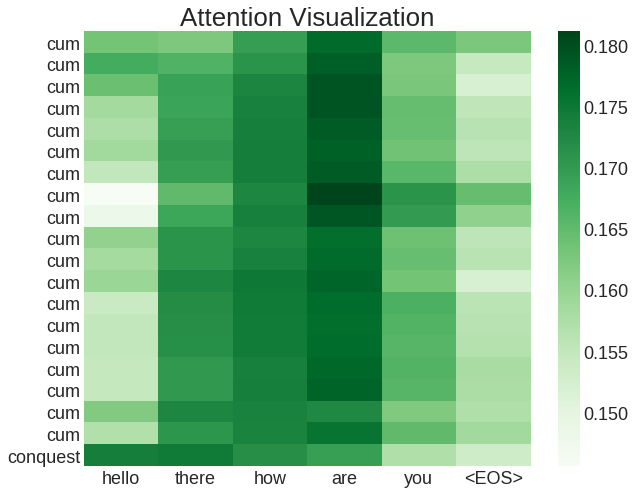

Seed_text hello there
Generated_lyrics conquest cum la la la la fantastic fantastic la fantastic la la chairs fantastic fantastic fantastic la la conquest la


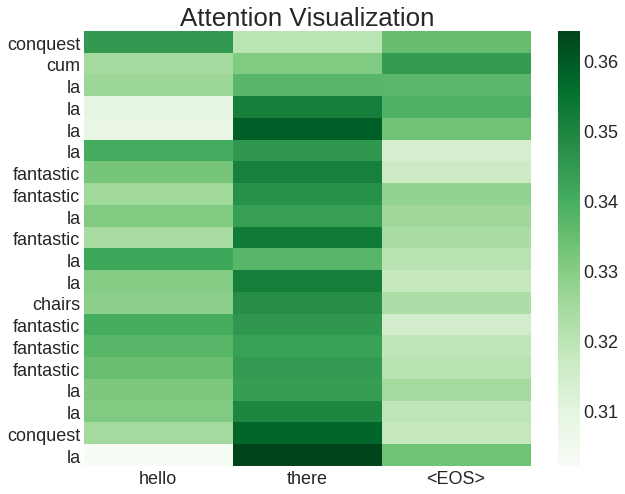